In [1]:
# Install Kaggle library
!pip install -q kaggle

# Make a directory for Kaggle and move the kaggle.json file there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Change the permissions of the file
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset from Kaggle
!kaggle datasets download -d mdkhurshidjahan01/figshare-brain-tumor-dataset

# Unzip the downloaded dataset
!unzip figshare-brain-tumor-dataset.zip -d brain_tumor_dataset

Dataset URL: https://www.kaggle.com/datasets/mdkhurshidjahan01/figshare-brain-tumor-dataset
License(s): Apache 2.0
 98% 425M/436M [00:04<00:00, 101MB/s]
100% 436M/436M [00:04<00:00, 113MB/s]
Archive:  figshare-brain-tumor-dataset.zip
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_103192.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_104263.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_105758.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_106611.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_107584.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_111735.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_114652.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_115499.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_121515.png  
  inflating: brain_tumor_dataset/Fig Share/Testing/glioma/image_135912.pn

Epoch 1/30, Train Loss: 0.2881317301100008, Train Acc: 0.8848509595753369, Valid Loss: 3.4740370546956014, Valid Acc: 0.30944625407166126
Epoch 2/30, Train Loss: 0.0930389255975864, Train Acc: 0.9661086157615354, Valid Loss: 4.187410604681953, Valid Acc: 0.30618892508143325
Epoch 3/30, Train Loss: 0.07222877071068305, Train Acc: 0.9734585545120458, Valid Loss: 4.640029893247623, Valid Acc: 0.2996742671009772
Epoch 4/30, Train Loss: 0.030006719228350274, Train Acc: 0.991016741527154, Valid Loss: 5.008389232213023, Valid Acc: 0.30618892508143325
Epoch 5/30, Train Loss: 0.020445775090066107, Train Acc: 0.9942833809718253, Valid Loss: 6.282361029025398, Valid Acc: 0.2899022801302932
Epoch 6/30, Train Loss: 0.02548790966354922, Train Acc: 0.9922417313189057, Valid Loss: 6.462775270791318, Valid Acc: 0.2964169381107492
Epoch 7/30, Train Loss: 0.0199010652431396, Train Acc: 0.9934667211106575, Valid Loss: 6.086116784558622, Valid Acc: 0.2964169381107492
Epoch 8/30, Train Loss: 0.0279275397060

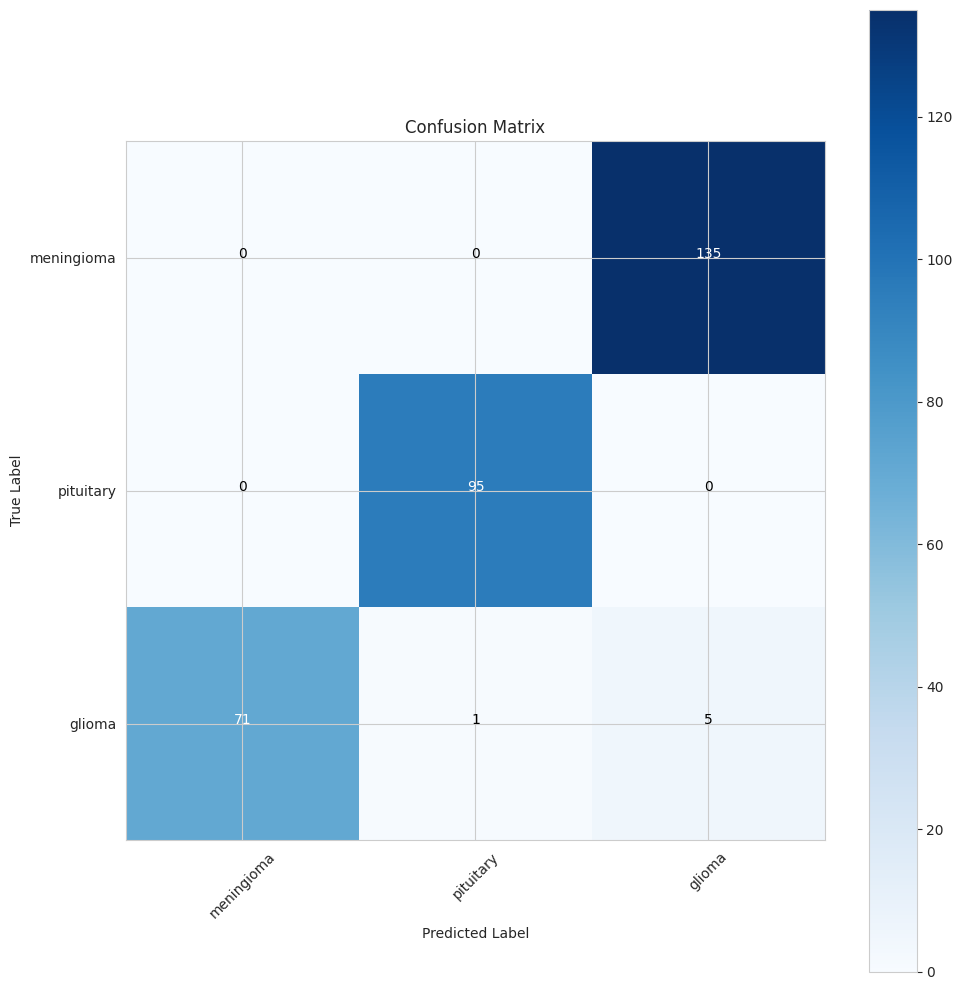

              precision    recall  f1-score   support

  meningioma       0.00      0.00      0.00       135
   pituitary       0.99      1.00      0.99        95
      glioma       0.04      0.06      0.05        77

    accuracy                           0.33       307
   macro avg       0.34      0.35      0.35       307
weighted avg       0.32      0.33      0.32       307



In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image

sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')

# Paths to your training and testing data
train_data_path = '/content/brain_tumor_dataset/Fig Share/Training'
test_data_path = '/content/brain_tumor_dataset/Fig Share/Testing'

# Create dataframes for training and testing data
def create_dataframe(data_path):
    filepaths = []
    labels = []
    folds = os.listdir(data_path)
    for fold in folds:
        f_path = os.path.join(data_path, fold)
        filelists = os.listdir(f_path)
        for file in filelists:
            filepaths.append(os.path.join(f_path, file))
            labels.append(fold)
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='label')
    return pd.concat([Fseries, Lseries], axis=1)

train_df = create_dataframe(train_data_path)
test_df = create_dataframe(test_data_path)

# Split test data into validation and test sets
valid_df, test_df = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=42)

img_size = (150, 150)
batch_size = 32

# Custom Dataset Class
class BrainTumorDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.label_map = {label: idx for idx, label in enumerate(df['label'].unique())}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx, 0]
        label = self.df.iloc[idx, 1]
        label = self.label_map[label]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)

# Transforms
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets and Dataloaders
train_dataset = BrainTumorDataset(train_df, transform=transform)
valid_dataset = BrainTumorDataset(valid_df, transform=transform)
test_dataset = BrainTumorDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the RegNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.regnet_y_400mf(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.BatchNorm1d(num_ftrs),
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, len(train_df['label'].unique()))
)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(), lr=0.001)

# Training Function
def train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=30):
    best_acc = 0.0
    train_acc_history = []
    train_loss_history = []
    valid_acc_history = []
    valid_loss_history = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects.double() / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc.item())

        model.eval()
        running_loss = 0.0
        corrects = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(valid_loader.dataset)
        epoch_acc = corrects.double() / len(valid_loader.dataset)
        valid_loss_history.append(epoch_loss)
        valid_acc_history.append(epoch_acc.item())

        if epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), 'best_model.pth')

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss_history[-1]}, Train Acc: {train_acc_history[-1]}, Valid Loss: {valid_loss_history[-1]}, Valid Acc: {valid_acc_history[-1]}')

    return train_acc_history, train_loss_history, valid_acc_history, valid_loss_history

train_acc_history, train_loss_history, valid_acc_history, valid_loss_history = train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=30)

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate the model
def evaluate_model(model, dataloader):
    model.eval()
    running_loss = 0.0
    corrects = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)

    loss = running_loss / len(dataloader.dataset)
    accuracy = corrects.double() / len(dataloader.dataset)
    return loss, accuracy.item()

train_loss, train_acc = evaluate_model(model, train_loader)
valid_loss, valid_acc = evaluate_model(model, valid_loader)
test_loss, test_acc = evaluate_model(model, test_loader)

print("Train Loss: ", train_loss)
print("Train Accuracy: ", train_acc)
print('-' * 20)
print("Validation Loss: ", valid_loss)
print("Validation Accuracy: ", valid_acc)
print('-' * 20)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_acc)

# Confusion Matrix and Classification Report
def get_all_preds(model, dataloader):
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            preds = model(inputs)
            all_preds = torch.cat((all_preds, preds.cpu()), dim=0)
            all_labels = torch.cat((all_labels, labels), dim=0)
    return all_preds, all_labels

test_preds, test_labels = get_all_preds(model, test_loader)
_, y_pred = torch.max(test_preds, 1)
cm = confusion_matrix(test_labels.numpy(), y_pred.numpy())

classes = list(train_df['label'].unique())
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(test_labels.numpy(), y_pred.numpy(), target_names=classes))

In [ ]:
cnn

In [11]:
import warnings
warnings.filterwarnings("ignore")
# import system libs
import os
import itertools
from PIL import Image

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

print ('modules loaded')

modules loaded


In [12]:
# Generate data paths with labels
train_data_dir = '/content/brain_tumor_dataset/Fig Share/Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
# print(folds)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# print(labels)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)

In [13]:
# Generate data paths with labels
test_data_dir = '/content/brain_tumor_dataset/Fig Share/Testing'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
ts_df = pd.concat([Fseries, Lseries], axis= 1)

In [14]:
# valid and test dataframe
valid_df, test_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 123)

In [15]:
# crobed image size
batch_size = 32
img_size = (150,150)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 2449 validated image filenames belonging to 3 classes.
Found 307 validated image filenames belonging to 3 classes.
Found 307 validated image filenames belonging to 3 classes.


Found 2449 validated image filenames belonging to 3 classes.
Found 307 validated image filenames belonging to 3 classes.
Found 307 validated image filenames belonging to 3 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 conv2d_17 (Conv2D)          (None, 150, 150, 16)      2320      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 75, 75, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 conv2d_19 (Conv2D)          (None, 75, 75, 32)        9248      
     

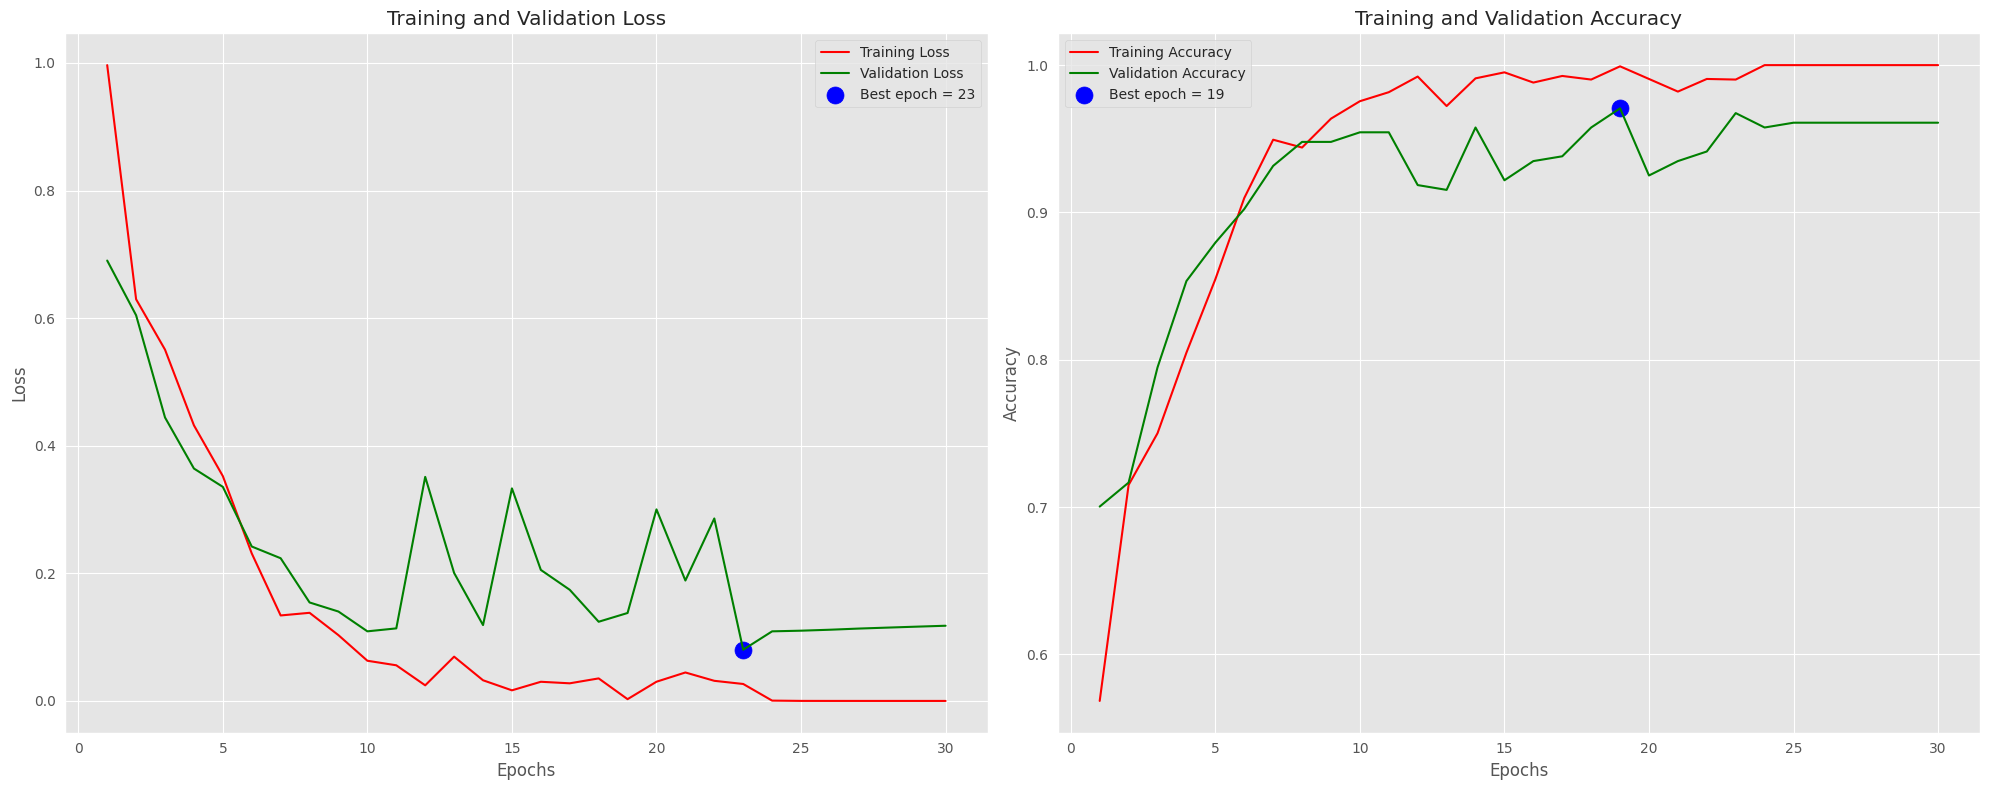

10/16 [=================>............] - ETA: 1s - loss: 0.1379 - accuracy: 0.9707

10/16 [=================>............] - ETA: 2s - loss: 0.2004 - accuracy: 0.9577

16/16 [==============================] - 4s 230ms/step - loss: 0.2004 - accuracy: 0.9577
Train Loss:  0.0029149402398616076
Train Accuracy:  1.0
--------------------
Validation Loss:  0.13786667585372925
Validation Accuracy:  0.9706840515136719
--------------------
Test Loss:  0.20036610960960388
Test Accuracy:  0.9576547145843506
10/10 [==============================] - 3s 257ms/step


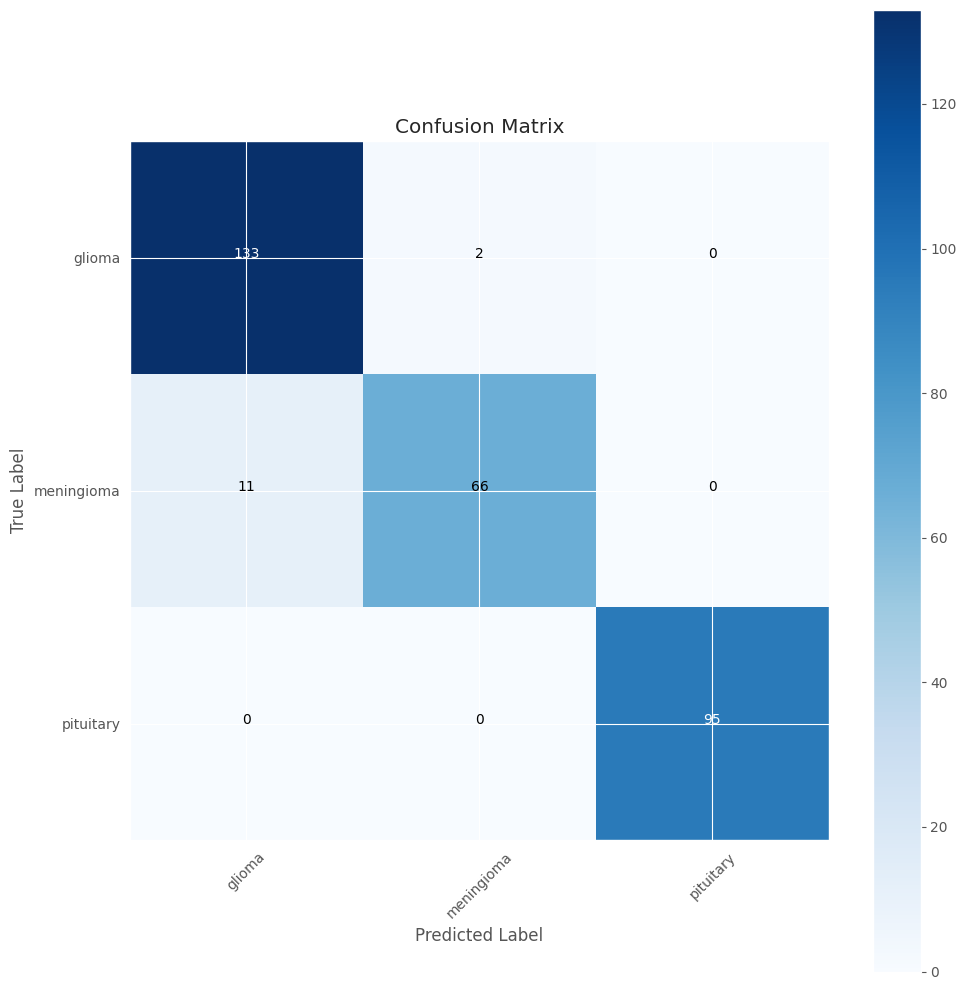

              precision    recall  f1-score   support

      glioma       0.92      0.99      0.95       135
  meningioma       0.97      0.86      0.91        77
   pituitary       1.00      1.00      1.00        95

    accuracy                           0.96       307
   macro avg       0.96      0.95      0.95       307
weighted avg       0.96      0.96      0.96       307



In [18]:
import os
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers

sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')

# Paths to your training and testing data
train_data_path = '/content/brain_tumor_dataset/Fig Share/Training'
test_data_path = '/content/brain_tumor_dataset/Fig Share/Testing'

# Create dataframes for training and testing data
def create_dataframe(data_path):
    filepaths = []
    labels = []
    folds = os.listdir(data_path)
    for fold in folds:
        f_path = os.path.join(data_path, fold)
        filelists = os.listdir(f_path)
        for file in filelists:
            filepaths.append(os.path.join(f_path, file))
            labels.append(fold)
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='label')
    return pd.concat([Fseries, Lseries], axis=1)

train_df = create_dataframe(train_data_path)
test_df = create_dataframe(test_data_path)

# Split test data into validation and test sets
valid, test = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=42)

img_size = (150, 150)
batch_size = 32

# ImageDataGenerators
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen = ts_gen.flow_from_dataframe(valid, x_col='filepaths', y_col='label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test, x_col='filepaths', y_col='label', target_size=img_size,
                                      class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

img_shape = (img_size[0], img_size[1], 3)
classes = train_gen.class_indices
num_class = len(classes)

# Define the CNN model
model = Sequential([
    Conv2D(filters=16, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1), input_shape=img_shape),
    Conv2D(filters=16, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    MaxPooling2D((2, 2)),

    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    MaxPooling2D((2, 2)),

    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation=LeakyReLU(alpha=0.1)),
    Dense(256, activation=LeakyReLU(alpha=0.1)),
    Dense(num_class, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

class TestAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_acc = model.evaluate(test_gen, verbose=0)
        print(f'\nTesting loss: {test_loss}, Testing accuracy: {test_acc}\n')

# Callback to save the best model
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

Epochs = 30
history = model.fit(x=train_gen, epochs=Epochs, verbose=1, validation_data=valid_gen,
                    validation_steps=None, shuffle=False, callbacks=[TestAccuracyCallback(), checkpoint])

# Load the best model
best_model = tf.keras.models.load_model('best_model.h5')

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i + 1 for i in range(len(train_acc))]

loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'

# Training history
plt.figure(figsize=(20, 8))
plt.style.use('ggplot')

plt.subplot(1, 2, 1)
plt.plot(Epochs, train_loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, val_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

train_score = best_model.evaluate(train_gen, steps=16, verbose=1)
valid_score = best_model.evaluate(valid_gen, steps=16, verbose=1)
test_score = best_model.evaluate(test_gen, steps=16, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

preds = best_model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(test_gen.classes, y_pred, target_names=classes))

Found 2449 validated image filenames belonging to 3 classes.
Found 307 validated image filenames belonging to 3 classes.
Found 307 validated image filenames belonging to 3 classes.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 conv2d_21 (Conv2D)          (None, 150, 150, 16)      2320      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 75, 75, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 conv2d_23 (Conv2D)          (None, 75, 75, 32)        9248      
     

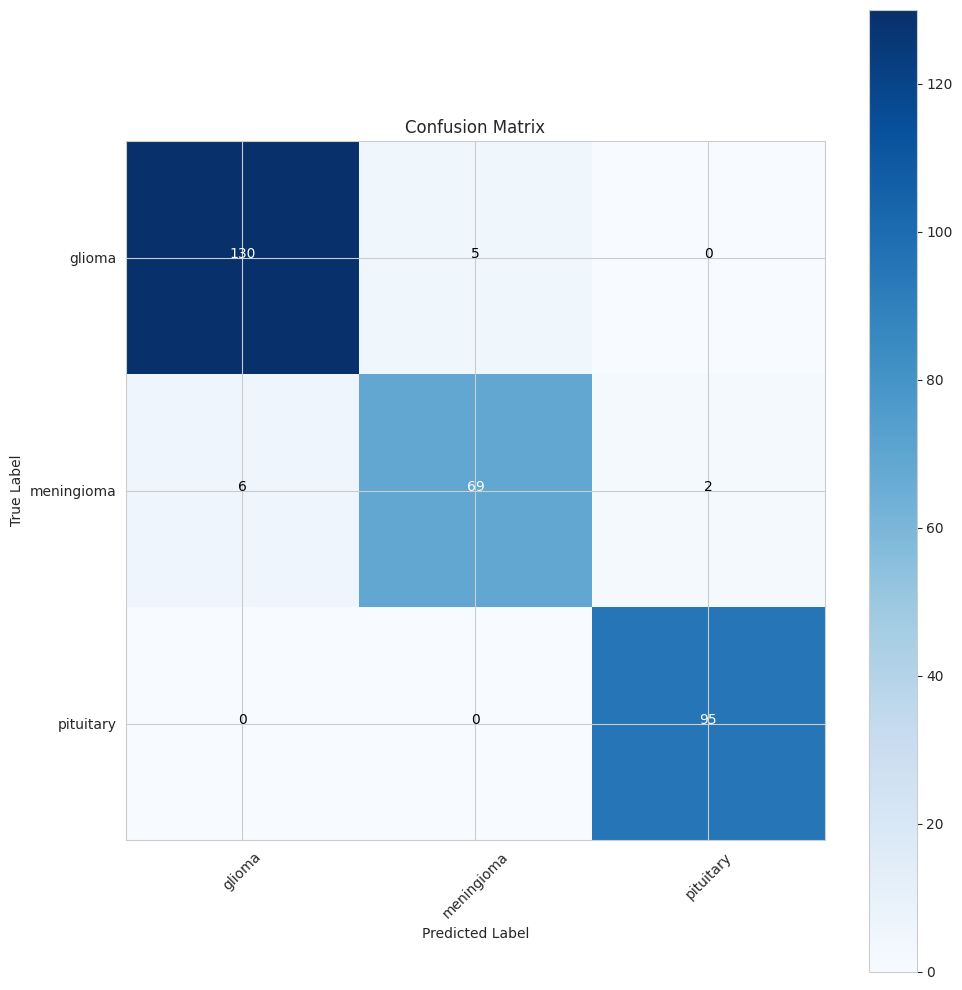

              precision    recall  f1-score   support

      glioma       0.96      0.96      0.96       135
  meningioma       0.93      0.90      0.91        77
   pituitary       0.98      1.00      0.99        95

    accuracy                           0.96       307
   macro avg       0.96      0.95      0.95       307
weighted avg       0.96      0.96      0.96       307



In [3]:
import os
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers

sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')

# Paths to your training and testing data
train_data_path = '/content/brain_tumor_dataset/Fig Share/Training'
test_data_path = '/content/brain_tumor_dataset/Fig Share/Testing'

# Create dataframes for training and testing data
def create_dataframe(data_path):
    filepaths = []
    labels = []
    folds = os.listdir(data_path)
    for fold in folds:
        f_path = os.path.join(data_path, fold)
        filelists = os.listdir(f_path)
        for file in filelists:
            filepaths.append(os.path.join(f_path, file))
            labels.append(fold)
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='label')
    return pd.concat([Fseries, Lseries], axis=1)

train_df = create_dataframe(train_data_path)
test_df = create_dataframe(test_data_path)

# Split test data into validation and test sets
valid, test = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=42)

img_size = (150, 150)
batch_size = 32

# ImageDataGenerators
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen = ts_gen.flow_from_dataframe(valid, x_col='filepaths', y_col='label', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test, x_col='filepaths', y_col='label', target_size=img_size,
                                      class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

img_shape = (img_size[0], img_size[1], 3)
classes = train_gen.class_indices
num_class = len(classes)

# Define the CNN model
model = Sequential([
    Conv2D(filters=16, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1), input_shape=img_shape),
    Conv2D(filters=16, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    MaxPooling2D((2, 2)),

    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    MaxPooling2D((2, 2)),

    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation=LeakyReLU(alpha=0.1)),
    Dense(256, activation=LeakyReLU(alpha=0.1)),
    Dense(num_class, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

class TestAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_acc = model.evaluate(test_gen, verbose=0)
        print(f'\nTesting loss: {test_loss}, Testing accuracy: {test_acc}\n')

# Callback to save the best model
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

Epochs = 30
history = model.fit(x=train_gen, epochs=Epochs, verbose=1, validation_data=valid_gen,
                    validation_steps=None, shuffle=False, callbacks=[TestAccuracyCallback(), checkpoint])

# Load the best model
best_model = tf.keras.models.load_model('best_model.h5')

# Evaluate on training, validation, and test sets
train_score = best_model.evaluate(train_gen, steps=len(train_gen), verbose=1)
valid_score = best_model.evaluate(valid_gen, steps=len(valid_gen), verbose=1)
test_score = best_model.evaluate(test_gen, steps=len(test_gen), verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

# Generate predictions
preds = best_model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

# Generate confusion matrix
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
cm = confusion_matrix(test_gen.classes, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print(classification_report(test_gen.classes, y_pred, target_names=classes))

In [4]:
from tensorflow.keras.layers import BatchNormalization, Dropout

model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1), input_shape=img_shape),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),

    Dense(512, activation=LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation=LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_class, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

class TestAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_acc = model.evaluate(test_gen, verbose=0)
        print(f'\nTesting loss: {test_loss}, Testing accuracy: {test_acc}\n')

# Callback to save the best model
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

Epochs = 30
history = model.fit(x=train_gen, epochs=Epochs, verbose=1, validation_data=valid_gen,
                    validation_steps=None, shuffle=False, callbacks=[TestAccuracyCallback(), checkpoint, lr_scheduler])

# Load the best model
best_model = tf.keras.models.load_model('best_model.h5')

# Evaluate on training, validation, and test sets
train_score = best_model.evaluate(train_gen, steps=len(train_gen), verbose=1)
valid_score = best_model.evaluate(valid_gen, steps=len(valid_gen), verbose=1)
test_score = best_model.evaluate(test_gen, steps=len(test_gen), verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

# Generate predictions
preds = best_model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

# Generate confusion matrix
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
cm = confusion_matrix(test_gen.classes, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print(classification_report(test_gen.classes, y_pred, target_names=classes))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_37 (Conv2D)          (None, 150, 150, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 150, 150, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 75, 75, 32)        0         
 ng2D)                                                           
                                                      

KeyboardInterrupt: 

In [5]:
from tensorflow.keras.layers import BatchNormalization, Dropout

model = Sequential([
    Conv2D(filters=16, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1), input_shape=img_shape),
    BatchNormalization(),
    Conv2D(filters=16, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),

    Dense(256, activation=LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation=LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_class, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

class TestAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_acc = model.evaluate(test_gen, verbose=0)
        print(f'\nTesting loss: {test_loss}, Testing accuracy: {test_acc}\n')

# Callback to save the best model
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

Epochs = 30
history = model.fit(x=train_gen, epochs=Epochs, verbose=1, validation_data=valid_gen,
                    validation_steps=None, shuffle=False, callbacks=[TestAccuracyCallback(), checkpoint, lr_scheduler])

# Load the best model
best_model = tf.keras.models.load_model('best_model.h5')

# Evaluate on training, validation, and test sets
train_score = best_model.evaluate(train_gen, steps=len(train_gen), verbose=1)
valid_score = best_model.evaluate(valid_gen, steps=len(valid_gen), verbose=1)
test_score = best_model.evaluate(test_gen, steps=len(test_gen), verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

# Generate predictions
preds = best_model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

# Generate confusion matrix
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
cm = confusion_matrix(test_gen.classes, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print(classification_report(test_gen.classes, y_pred, target_names=classes))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 batch_normalization_10 (Ba  (None, 150, 150, 16)      64        
 tchNormalization)                                               
                                                                 
 conv2d_45 (Conv2D)          (None, 150, 150, 16)      2320      
                                                                 
 batch_normalization_11 (Ba  (None, 150, 150, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 75, 75, 16)        0         
 ng2D)                                                           
                                                      

KeyboardInterrupt: 

In [6]:
from tensorflow.keras.layers import BatchNormalization, Dropout

model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1), input_shape=img_shape),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),

    Dense(256, activation=LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation=LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_class, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

class TestAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_acc = model.evaluate(test_gen, verbose=0)
        print(f'\nTesting loss: {test_loss}, Testing accuracy: {test_acc}\n')

# Callback to save the best model
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

Epochs = 30
history = model.fit(x=train_gen, epochs=Epochs, verbose=1, validation_data=valid_gen,
                    validation_steps=None, shuffle=False, callbacks=[TestAccuracyCallback(), checkpoint, lr_scheduler])

# Load the best model
best_model = tf.keras.models.load_model('best_model.h5')

# Evaluate on training, validation, and test sets
train_score = best_model.evaluate(train_gen, steps=len(train_gen), verbose=1)
valid_score = best_model.evaluate(valid_gen, steps=len(valid_gen), verbose=1)
test_score = best_model.evaluate(test_gen, steps=len(test_gen), verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

# Generate predictions
preds = best_model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

# Generate confusion matrix
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
cm = confusion_matrix(test_gen.classes, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print(classification_report(test_gen.classes, y_pred, target_names=classes))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 batch_normalization_20 (Ba  (None, 150, 150, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_53 (Conv2D)          (None, 150, 150, 32)      9248      
                                                                 
 batch_normalization_21 (Ba  (None, 150, 150, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 75, 75, 32)        0         
 ng2D)                                                           
                                                      

KeyboardInterrupt: 

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_58 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 batch_normalization_28 (Ba  (None, 150, 150, 16)      64        
 tchNormalization)                                               
                                                                 
 conv2d_59 (Conv2D)          (None, 150, 150, 16)      2320      
                                                                 
 batch_normalization_29 (Ba  (None, 150, 150, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 75, 75, 16)        0         
 ng2D)                                                           
                                                      

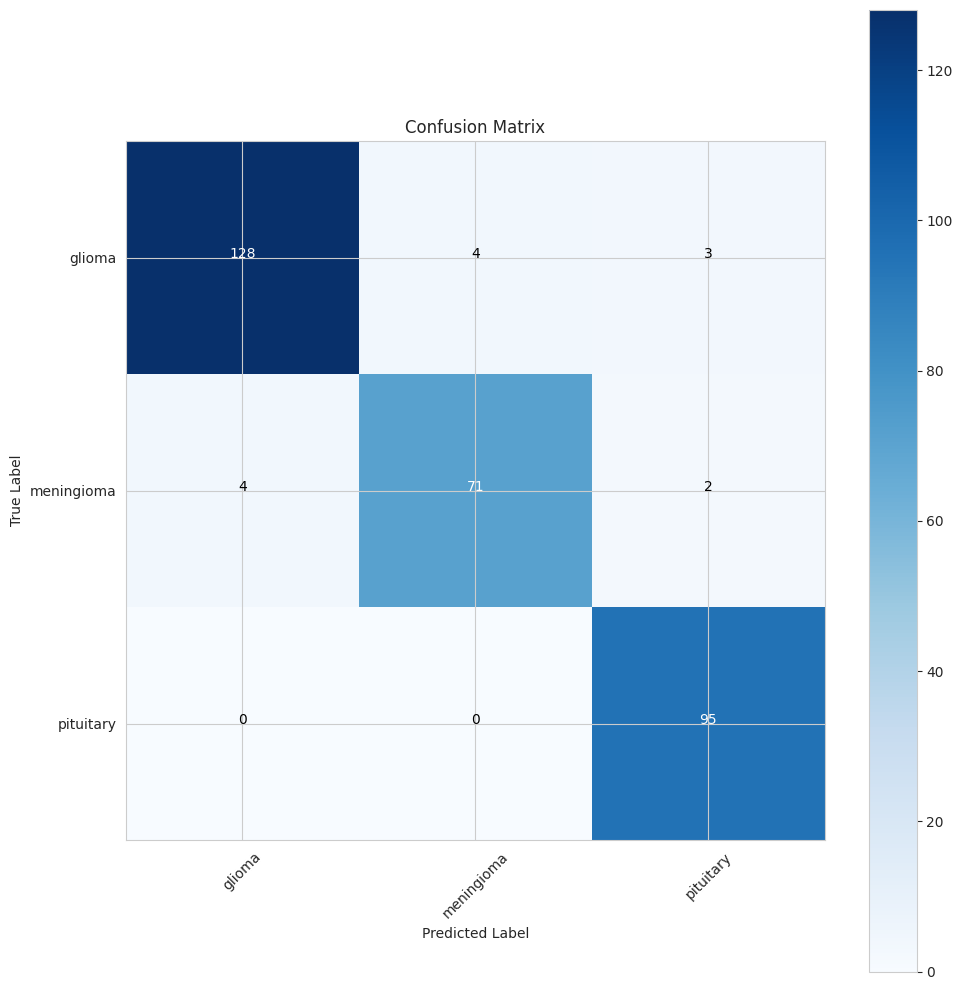

              precision    recall  f1-score   support

      glioma       0.97      0.95      0.96       135
  meningioma       0.95      0.92      0.93        77
   pituitary       0.95      1.00      0.97        95

    accuracy                           0.96       307
   macro avg       0.96      0.96      0.96       307
weighted avg       0.96      0.96      0.96       307



In [7]:
from tensorflow.keras.layers import BatchNormalization, Dropout

model = Sequential([
    Conv2D(filters=16, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1), input_shape=img_shape),
    BatchNormalization(),
    Conv2D(filters=16, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=LeakyReLU(alpha=0.1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),

    Dense(128, activation=LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation=LeakyReLU(alpha=0.1), kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_class, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

class TestAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_acc = model.evaluate(test_gen, verbose=0)
        print(f'\nTesting loss: {test_loss}, Testing accuracy: {test_acc}\n')

# Callback to save the best model
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

Epochs = 30
history = model.fit(x=train_gen, epochs=Epochs, verbose=1, validation_data=valid_gen,
                    validation_steps=None, shuffle=False, callbacks=[TestAccuracyCallback(), checkpoint, lr_scheduler])

# Load the best model
best_model = tf.keras.models.load_model('best_model.h5')

# Evaluate on training, validation, and test sets
train_score = best_model.evaluate(train_gen, steps=len(train_gen), verbose=1)
valid_score = best_model.evaluate(valid_gen, steps=len(valid_gen), verbose=1)
test_score = best_model.evaluate(test_gen, steps=len(test_gen), verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

# Generate predictions
preds = best_model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

# Generate confusion matrix
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
cm = confusion_matrix(test_gen.classes, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print(classification_report(test_gen.classes, y_pred, target_names=classes))